In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import matplotlib.style as style
from matplotlib.lines import Line2D

sns.set_style('white')
palette = ["#1b4079", "#C6DDF0", "#50723C", "#B9E28C", "#8C2155", "#AF7595", "#E6480F", "#FA9500"]
sns.set(palette = palette, font_scale=2.0, style="white", rc={"lines.linewidth": 3.0})
import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.train_utils import TrainVolModel, TrainVoltMagpieModel, LearnGPCV, TrainDataModel

Warning no robinhood utils.


## Generate Some Synthetic SDE Data

In [2]:
np.random.seed(2019)
torch.random.manual_seed(2019)

F0 = 10 ## init price
V0 = 0.2 ## init price
mu = 0.05 ## rate of return

alpha = 1.25
beta = 0.9
rho = -0.2

T = 1 ## Time of Simulation
steps = 400 ## steps per time
dt = T/(steps) ## delta t

dW = np.random.normal(0, np.sqrt(dt), steps*T)
dZ = rho * dW + np.sqrt(1 - rho **2) * np.random.normal(0, np.sqrt(dt), steps*T)


train_x = time = torch.linspace(0, T, steps-1) + dt
test_x = torch.linspace(T + dt, 1.5*T, int(.5*steps)-1) + dt



In [3]:
F = np.zeros(steps*T)
V = np.zeros(steps*T)

F[0] = F0
V[0] = V0

for t in range(1, steps*T):
    F[t] = F[t-1] + V[t-1] * (F[t-1])**beta * dW[t]
    V[t] = V[t-1] + alpha * V[t-1]*dZ[t]

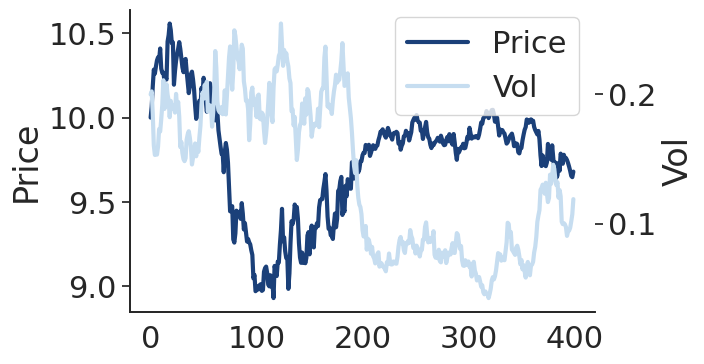

In [4]:
fig, ax = plt.subplots(dpi=100)
ax.plot(F, label='Price')
ax2 = ax.twinx()
ax2.plot(V, color = palette[1], label='Vol')

ax.set_ylabel("Price")
ax2.set_ylabel("Vol")

fig.legend(bbox_to_anchor=(0.9, 0.9))
sns.despine()
plt.show()

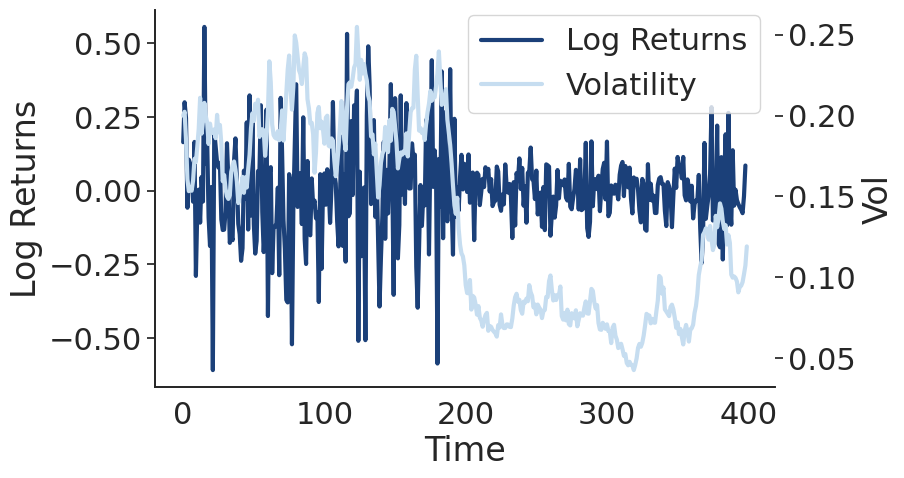

In [5]:
log_returns = (F[1:] - F[:-1]) / (F[:-1]**beta) / dt**0.5
fig, ax = plt.subplots(figsize = (8, 5), dpi=100, facecolor = "w")
ax.plot(log_returns, label='Log Returns')
ax2 = ax.twinx()
ax2.plot(V, color = palette[1], label='Volatility')

ax.set_ylabel("Log Returns")
ax2.set_ylabel("Vol")
ax.set_xlabel("Time")
fig.legend(bbox_to_anchor=(0.9, 0.9))
sns.despine()
plt.show();

## Learning A Volatility Model

While we show the volatility in the plot above, we do not typically get to observe this path directly. Therefore the first step in the Volt modeling pipeline is to learn a model of the historic volatility. For this we rely on [GCPV](https://arxiv.org/abs/1006.1350).

First specify the train and test domains

In [6]:
full_x = torch.FloatTensor(np.linspace(0, T, steps-1)) + dt
full_y = torch.FloatTensor(log_returns)

train_x = full_x
train_y = full_y

In [7]:
likelihood = VolatilityGaussianLikelihood(param="exp")
# likelihood.raw_a.data -= 4.
covar_module = BMKernel()
model = SingleTaskVariationalGP(
    init_points=train_x.view(-1,1), likelihood=likelihood, use_piv_chol_init=False,
    mean_module = gpytorch.means.ConstantMean(), covar_module=covar_module, 
    learn_inducing_locations=False, use_whitened_var_strat=False
)
model.initialize_variational_parameters(likelihood, train_x, y=train_y)

training_iterations = 500

model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {"params": model.parameters()}, 
    # {"params": likelihood.parameters(), "lr": 0.1}
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel(), combine_terms = True)

print_every = 50
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.num_gauss_hermite_locs(75):
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()


/home/greg_b/Volt/voltron/models/single_task_variational_gp.py:224: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  (0.5 * y.pow(-2.0) * (f * 2.0).exp()).T
/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130

Iter 1/500 - Loss: 12.325
Iter 51/500 - Loss: -0.461
Iter 101/500 - Loss: -0.561
Iter 151/500 - Loss: -0.579
Iter 201/500 - Loss: -0.581
Iter 251/500 - Loss: -0.581
Iter 301/500 - Loss: -0.580
Iter 351/500 - Loss: -0.581
Iter 401/500 - Loss: -0.581
Iter 451/500 - Loss: -0.581


In [8]:
model.eval();
likelihood.eval();
predictive = model(full_x)
pred_scale = likelihood(predictive, return_gaussian=False).scale.mean(0).detach()

## Now Train the Volt Model

Given the GCPV volatility path we can now train a GP over the historic volatility, and then learn the final Volt model to forecast with.

In [9]:
vmod, vlh = TrainVolModel(train_x, pred_scale, train_iters=500, printing=True)

In [11]:
dmod, dlh = TrainDataModel(train_x, torch.FloatTensor(F)[1:], vmod, vlh, pred_scale)

## Sampling

We now have a trained data model which is the main Volt class. To forecast we specify how many volatility paths we want to draw, `nvol`, and how many price paths we want to draw for each volatility path, `npx`. Then we simply loop through and draw the corresponding samples using the `GeneratePrediction` method.

In [24]:
dmod.eval();
dlh.eval();
dmod.vol_model.eval();

nvol = 8
npx = 1
px_paths = torch.zeros(npx*nvol, test_x.shape[0])
vol_paths = torch.zeros(nvol, test_x.shape[0])

for vidx in range(nvol):
#     print(vidx)
    vol_pred = dmod.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    px_pred = dmod.GeneratePrediction(test_x, vol_pred, npx).exp()
    px_paths[vidx*npx:(vidx*npx + npx), :] = px_pred.detach().T

## Put It All Together

Below we plot the full hierarchy - the learned volatility path, the predicted volatility paths into the future, and the predicted paths conditioned on the predicted volatility paths.

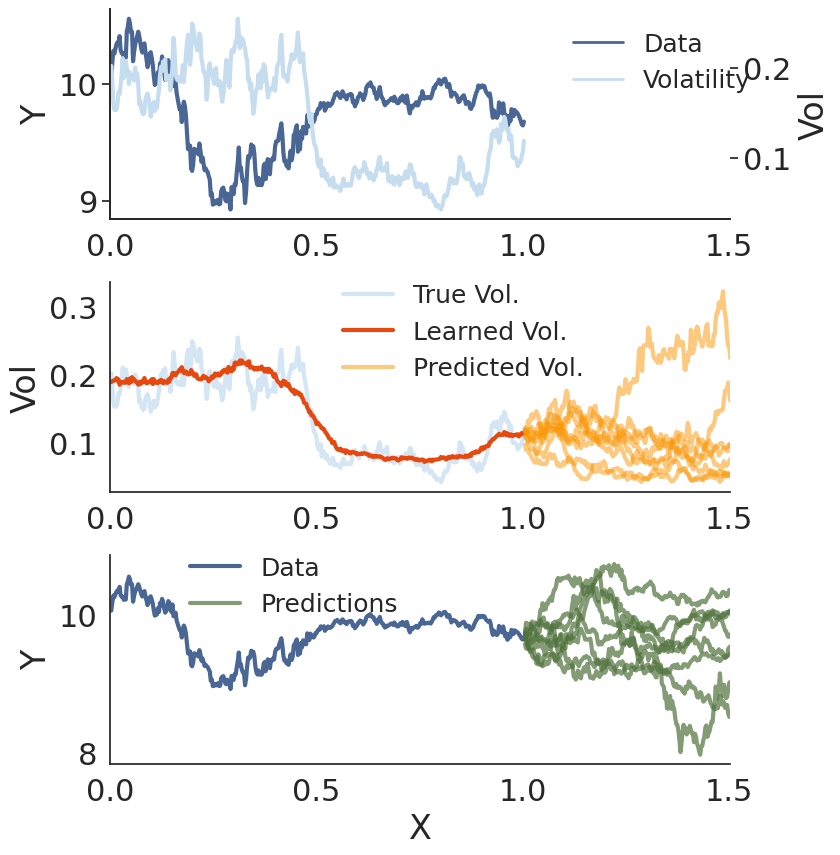

In [26]:
def FormatAx(ax):
    ax.set_xlim(0, test_x.max())
#     ax.axvline(train_time.max(), ls="--", c='k', lw=0.5)

fig, ax = plt.subplots(3, 1, figsize = (8, 10), dpi=100, facecolor = "w")
plt.subplots_adjust(hspace=0.3)

## vol & log return plot ##
ax[0].plot(train_x, F[1:], label='Data', alpha=0.8)
ax2 = ax[0].twinx()
ax2.plot(train_x, V[1:], color = palette[1], label='Volatility')
ax[0].set_ylabel("Y")
ax2.set_ylabel("Vol")
# ax[0].legend(bbox_to_anchor=(0.9, 0.9))

custom_lines = [Line2D([0], [0], color=palette[0], lw=2., alpha=0.8,label="Data"),
                Line2D([0], [0], color=palette[1], lw=2., label="Volatility")]

ax[0].legend(handles=custom_lines,loc="upper right", bbox_to_anchor=(1.07, 1.), 
             frameon=False, fontsize=18)


## Vol and Forecast Plot ##
ax[1].plot(train_x, V[1:], color = palette[1], alpha=0.75, label="True Vol.")
ax[1].plot(train_x, pred_scale, color = palette[-2], label = "Learned Vol.")
ax[1].plot(test_x, vol_paths[0, :].T, color=palette[-1], alpha=0.5, label="Predicted Vol.")
ax[1].plot(test_x, vol_paths[1:, :].T, color=palette[-1], alpha=0.5)
ax[1].set_ylabel("Vol")
ax[1].legend(loc="upper right", bbox_to_anchor=(0.8, 1.1), frameon=False, fontsize=18)

## Price and Forecast Plot ##
ax[2].plot(train_x, F[1:], color=palette[0], alpha=0.8, label="Data")
ax[2].plot(test_x, px_paths[1:10, :].T, color=palette[2], alpha=0.7)
ax[2].plot(test_x, px_paths[0, :].T, color=palette[2], alpha=0.7, label="Predictions")
ax[2].set_ylabel("Y")
ax[2].set_xlabel("X")
ax[2].legend(loc="upper right", bbox_to_anchor=(0.5, 1.1), frameon=False, fontsize=18)
## General Adjustments ##
FormatAx(ax[0])
FormatAx(ax[1])
FormatAx(ax[2])

sns.despine()
plt.show()

## Note:

There are some helpful utilities for training and forecasting that are used in the experimental code - we encourage you to play around with these utilities and try out Volt on new problems!